In [ ]:
# Install PySpark if not available in Colab
!pip install pyspark

# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, from_unixtime, count, hour, dayofweek, avg, trim, lower, desc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import re
from collections import Counter

In [ ]:
spark = (
    SparkSession.builder
    .appName("BusinessReviewAnalysis")
    .config("spark.driver.memory", "8g")            # bump driver heap
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")  # faster, lower-overhead conversion
    .getOrCreate()
)

# Load CSV files
reviews = spark.read.csv("review.csv", header=True, inferSchema=True)
meta = spark.read.csv("meta-review-business.csv", header=True, inferSchema=True)

# --- Print schema + top 5 for reviews ---
print("=== reviews schema ===")
reviews.printSchema()
print("\n=== reviews top 5 ===")
reviews.show(5, truncate=False)

# --- Print schema + top 5 for meta ---
print("=== meta schema ===")
meta.printSchema()
print("\n=== meta top 5 ===")
meta.show(5, truncate=False)

# Join dataframes on gmap_id
reviews_clean = reviews.withColumnRenamed("name", "reviewer_name").withColumnRenamed("rating", "review_rating")
meta_clean = meta.withColumnRenamed("name", "business_name")

joined_df = reviews_clean.join(meta_clean, on="gmap_id", how="inner")

# --- Print schema + top 5 for joined_df ---
print("=== joined_df schema ===")
joined_df.printSchema()
print("\n=== joined_df top 5 ===")
joined_df.show(5, truncate=False)

=== reviews schema ===
root
 |-- user_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)


=== reviews top 5 ===
+---------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------+-------------+---------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+----+--------------------------

# **Answer 1.1**

In [ ]:
# Q1.1 — PySpark wrangling on joined_df
# 1.1.1 Replace None/null (and literal "none"/"null" or empty strings) in `text` with "no review"
joined_df = joined_df.withColumn(
    "text",
    when(
        col("text").isNull() | (trim(lower(col("text"))).isin("", "none", "null")),
        "no review"
    ).otherwise(col("text"))
)

# 1.1.2 Convert epoch-milliseconds `time` to date string "yyyy-MM-dd" in new column `newtime`
# Cast time to BIGINT in case it was read as string, divide by 1000 to get seconds
joined_df = joined_df.withColumn(
    "newtime",
    from_unixtime(col("time").cast("bigint")/1000, "yyyy-MM-dd")
)

# Show first 5 rows with key columns
joined_df.select(
    "reviewer_name",  # from reviews
    "business_name",  # from meta
    "time",
    "newtime",
    "text"
).show(5, truncate=False)


+-------------+---------------------------+-------------+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|reviewer_name|business_name              |time         |newtime   |text                                                                                                                                                                                                                                                                                                                                          |
+-------------+---------------------------+-------------+----------+----------------------------------------------------------------------------------------------------------------------------

# **Answer 1.2**

In [ ]:
# Q1.2.1 — Count reviews per gmap_id (as float) with PySpark
review_counts = joined_df.groupBy("gmap_id").agg(
    count("*").cast("float").alias("num_reviews")
)

print("=== Top 5 gmap_id with review counts ===")
review_counts.show(5, truncate=False)

=== Top 5 gmap_id with review counts ===
+-------------------------------------+-----------+
|gmap_id                              |num_reviews|
+-------------------------------------+-----------+
|0x56c8977642a793f5:0xab9f95aa9c585a46|24.0       |
|0x56c79c63a5af15e3:0x117ca44b9578b995|10.0       |
|0x56c8976e16705e63:0x787e5d94ea9d2387|49.0       |
|0x51325aac7a4434e5:0xfbed5197982b41ae|28.0       |
|0x56c6631e32190947:0x7620b39117ffbb62|12.0       |
+-------------------------------------+-----------+
only showing top 5 rows



In [ ]:
# Add review_time (hour) in Spark (cheap)
joined_df = joined_df.withColumn("review_time", hour(from_unixtime(col("time").cast("bigint")/1000)))

# Select minimal columns before collecting
cols_needed = ["gmap_id", "business_name", "reviewer_name", "time", "newtime", "review_time"]
df = joined_df.select(*cols_needed).toPandas()

print(df.head())

                                 gmap_id                business_name  \
0  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
1  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
2  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
3  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   
4  0x56b646ed2220b77f:0xd8975e316de80952  Bear Creek Cabins & RV Park   

   reviewer_name           time     newtime  review_time  
0     Nicki Gore  1566331951619  2019-08-20         20.0  
1     Nicki Gore  1566331951619  2019-08-20         20.0  
2  Allen Ratliff  1504917982385  2017-09-09          0.0  
3  Allen Ratliff  1504917982385  2017-09-09          0.0  
4         S Blad  1472858535682  2016-09-02         23.0  


/tmp/ipython-input-1890511607.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=ax3, x="daypart", y="num_reviews", data=daypart_counts, palette="Set2")


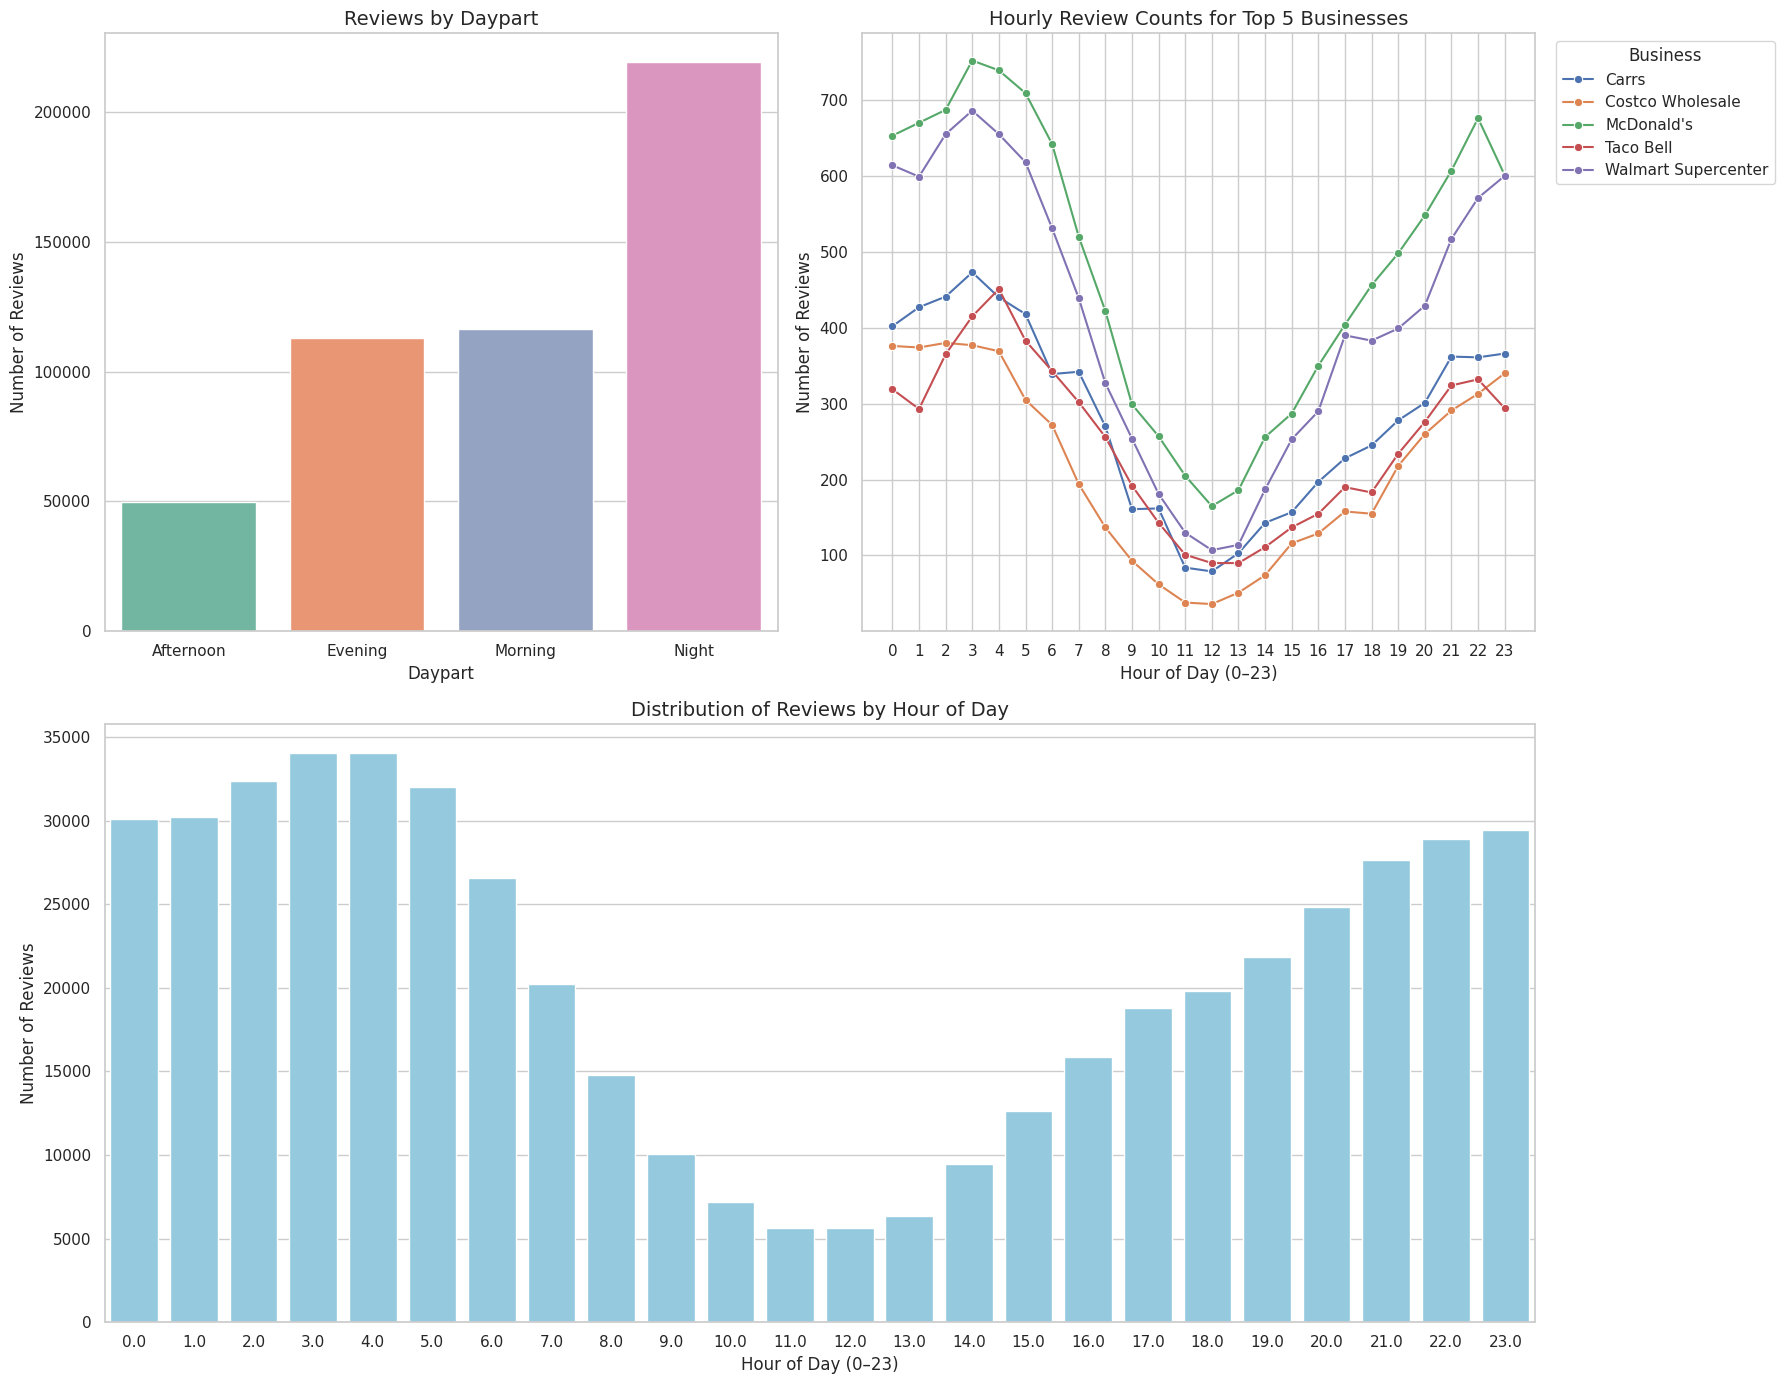

In [ ]:
# Q1.2.3 — Visualizations in 2+1 Layout
# Make sure review_time exists
joined_df = joined_df.withColumn("review_time", hour(from_unixtime(col("time").cast("bigint")/1000)))

# 1) Overall hourly counts
hourly_counts = (
    joined_df.groupBy("review_time")
    .agg(count("*").alias("num_reviews"))
    .orderBy("review_time")
    .toPandas()
)

# 2) Top 5 businesses by hourly reviews
top5_biz = (
    joined_df.groupBy("business_name").agg(count("*").alias("tot"))
    .orderBy(desc("tot"))
    .limit(5)
)
biz_hour_counts = (
    joined_df.join(top5_biz.select("business_name"), on="business_name", how="inner")
    .groupBy("business_name", "review_time")
    .agg(count("*").alias("num_reviews"))
    .orderBy("business_name", "review_time")
    .toPandas()
)

# 3) Reviews by daypart
joined_df = joined_df.withColumn(
    "daypart",
    when((col("review_time") >= 5) & (col("review_time") < 12), "Morning")
    .when((col("review_time") >= 12) & (col("review_time") < 17), "Afternoon")
    .when((col("review_time") >= 17) & (col("review_time") < 22), "Evening")
    .otherwise("Night")
)
daypart_counts = (
    joined_df.groupBy("daypart")
    .agg(count("*").alias("num_reviews"))
    .orderBy("daypart")
    .toPandas()
)

# ========== PLOT IN GRID ==========
fig = plt.figure(figsize=(18, 14))

# Plot 1: Overall hourly distribution (top-left)
ax1 = plt.subplot2grid((2,2), (1,0), colspan=2)
sns.barplot(ax=ax1, x="review_time", y="num_reviews", data=hourly_counts, color="skyblue")
ax1.set_title("Distribution of Reviews by Hour of Day", fontsize=14)
ax1.set_xlabel("Hour of Day (0–23)")
ax1.set_ylabel("Number of Reviews")
ax1.set_xticks(range(0,24))

# Plot 2: Top 5 businesses hourly distribution (top-right)
ax2 = plt.subplot2grid((2,2), (0,1))
sns.lineplot(ax=ax2, data=biz_hour_counts, x="review_time", y="num_reviews",
             hue="business_name", marker="o")
ax2.set_title("Hourly Review Counts for Top 5 Businesses", fontsize=14)
ax2.set_xlabel("Hour of Day (0–23)")
ax2.set_ylabel("Number of Reviews")
ax2.set_xticks(range(0,24))
ax2.legend(title="Business", bbox_to_anchor=(1.02, 1), loc="upper left")

# Plot 3: Reviews by Daypart (bottom row spanning full width)
ax3 = plt.subplot2grid((2,2), (0,0))
sns.barplot(ax=ax3, x="daypart", y="num_reviews", data=daypart_counts, palette="Set2")
ax3.set_title("Reviews by Daypart", fontsize=14)
ax3.set_xlabel("Daypart")
ax3.set_ylabel("Number of Reviews")

plt.tight_layout()
plt.show()


# **Observations**
## **1. Reviews by Daypart**
* The night time has the highest number of reviews overall, followed by morning and evening.
* Afternoon is the least active period.
* This suggests that users often leave reviews late at night (possibly after visiting a business or when they’re back home and reflecting on the experience).

## **2. Hourly Review Counts for Top 5 Businesses**
* The pattern across all businesses shows a clear dip around mid-day (11 AM–1 PM) when fewer reviews are posted.
* Peaks occur during the early morning hours (around 2–5 AM) and then again during the late evening/night (8 PM–11 PM).
### **Among the businesses:**
* Costco Wholesale and Walmart Supercenter receive the highest volume of reviews consistently.
* Fast food places like McDonald’s and Taco Bell have similar but smaller peaks, showing people tend to review them in the evening or night after visits.

## **3. Distribution of Reviews by Hour of Day (All Businesses)**
* The distribution confirms that reviews surge between 1 AM and 5 AM, stay lower throughout the day, and rise again after 6 PM, reaching another peak close to midnight.
* The lowest activity is between 10 AM–2 PM, which aligns with working hours when people are less likely to post reviews.

# **Insights**
* People prefer writing reviews at night/early morning, likely because they have more free time.
* Morning reviews (around 7–9 AM) could be from travelers or people leaving reviews right after breakfast/lodging checkouts.
* Top businesses with high customer volume (like Walmart, Costco) naturally attract more reviews, but the timing trend still follows the same late-night/early-morning spike.
* Businesses could monitor review submissions late at night to respond quickly and engage users while the memory of the visit is fresh.

# **Answer 1.3**

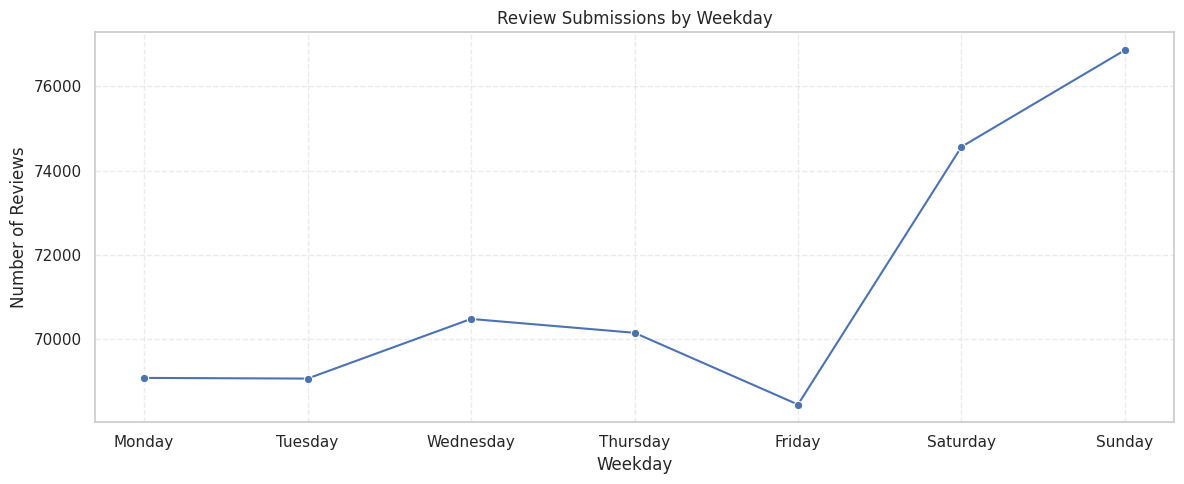

Weekday with most reviews: Sunday


In [ ]:
# Q1.3.1 — Weekday with most reviews (line chart)
# Derive weekday name from epoch-ms time (uses your existing joined_df)
joined_df = joined_df.withColumn(
    "weekday",
    F.date_format(F.from_unixtime(F.col("time").cast("bigint")/1000), "EEEE")
)

# Count reviews per weekday
weekday_counts_pd = (
    joined_df.groupBy("weekday")
    .agg(F.count("*").alias("num_reviews"))
    .toPandas()
)

# Order weekdays Mon..Sun for readability
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_counts_pd["weekday"] = pd.Categorical(weekday_counts_pd["weekday"], categories=weekday_order, ordered=True)
weekday_counts_pd = weekday_counts_pd.sort_values("weekday")

# Plot line chart
plt.figure(figsize=(12,5))
sns.lineplot(data=weekday_counts_pd, x="weekday", y="num_reviews", marker="o")
plt.title("Review Submissions by Weekday")
plt.xlabel("Weekday")
plt.ylabel("Number of Reviews")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

top_weekday = weekday_counts_pd.loc[weekday_counts_pd["num_reviews"].idxmax(), "weekday"]
print("Weekday with most reviews:", top_weekday)


# **Observations**
## **Weekday vs. Weekend Split**
* Reviews are consistently lower during weekdays (Monday to Friday).
* There is a sharp increase on Saturday and Sunday, with Sunday having the highest number of reviews overall.

## **Lowest Point**
* Friday records the least number of reviews, slightly below Monday and Tuesday.
* This suggests people are less likely to leave reviews right before the weekend.

## **Highest Point**
* Sunday stands out as the peak review submission day, crossing ~76,000 reviews.
* Saturday also shows a significant rise compared to weekdays, indicating a strong weekend trend.

## **Midweek Stability**
* From Monday to Thursday, the number of reviews remains relatively stable with minor fluctuations (~69,000–70,500).
* Wednesday sees a small bump, but it’s not as significant compared to the weekend surge.

# **Insights**
* **User Behavior:** Customers are more likely to leave reviews during the weekend, when they have free time to reflect on their experiences.
* **Business Implication:** Companies should monitor and respond to reviews more actively on weekends, especially on Sundays, to engage with the peak volume of customer feedback.
* **Marketing Strategy:** Encouraging review requests might be more effective on weekends, aligning with when people are naturally posting more.

In [ ]:
# Q1.3.2 — Top businesses (names from meta) with highest average ratings on the busiest weekday
from pyspark.sql import functions as F

# Filter to the busiest weekday found above
peak_reviews = joined_df.filter(F.col("weekday") == F.lit(top_weekday))

# Compute average review_rating per business and include category + support count
biz_peak_ratings = (
    peak_reviews.groupBy("business_name", "category")
    .agg(
        F.avg("review_rating").alias("avg_review_rating"),
        F.count("*").alias("n_reviews")
    )
    .orderBy(F.desc("avg_review_rating"), F.desc("n_reviews"))
)

biz_peak_ratings.show(10, truncate=False)

# Optionally collect a small table to Pandas for the report
biz_peak_ratings_pd = biz_peak_ratings.toPandas()
print(biz_peak_ratings_pd.head(10))


+--------------------------------------------------------+--------------------------------------------------------------------------------------+-----------------+---------+
|business_name                                           |category                                                                              |avg_review_rating|n_reviews|
+--------------------------------------------------------+--------------------------------------------------------------------------------------+-----------------+---------+
|All Creatures Veterinary Clinic                         |['Veterinarian']                                                                      |5.0              |22       |
|Little Mermaid                                          |['Seafood restaurant', 'American restaurant']                                         |5.0              |18       |
|Anchorage Ace Hardware                                  |['Hardware store', 'Home improvement store', 'Paint store', 'Tool store'

=== Reviews by Category on Sunday (Top 10) ===
                                                                                                                                                                                                              category  num_reviews
                                                                                                                                                                                                     ['Shopping mall']         1952
                                                                                                ['Fast food restaurant', 'Breakfast restaurant', 'Coffee shop', 'Hamburger restaurant', 'Restaurant', 'Sandwich shop']         1640
                                 ['Department store', 'Clothing store', 'Craft store', 'Discount store', 'Electronics store', 'Grocery store', 'Home goods store', 'Sporting goods store', 'Supermarket', 'Toy store']         1470
                                         

/tmp/ipython-input-4195989819.py:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


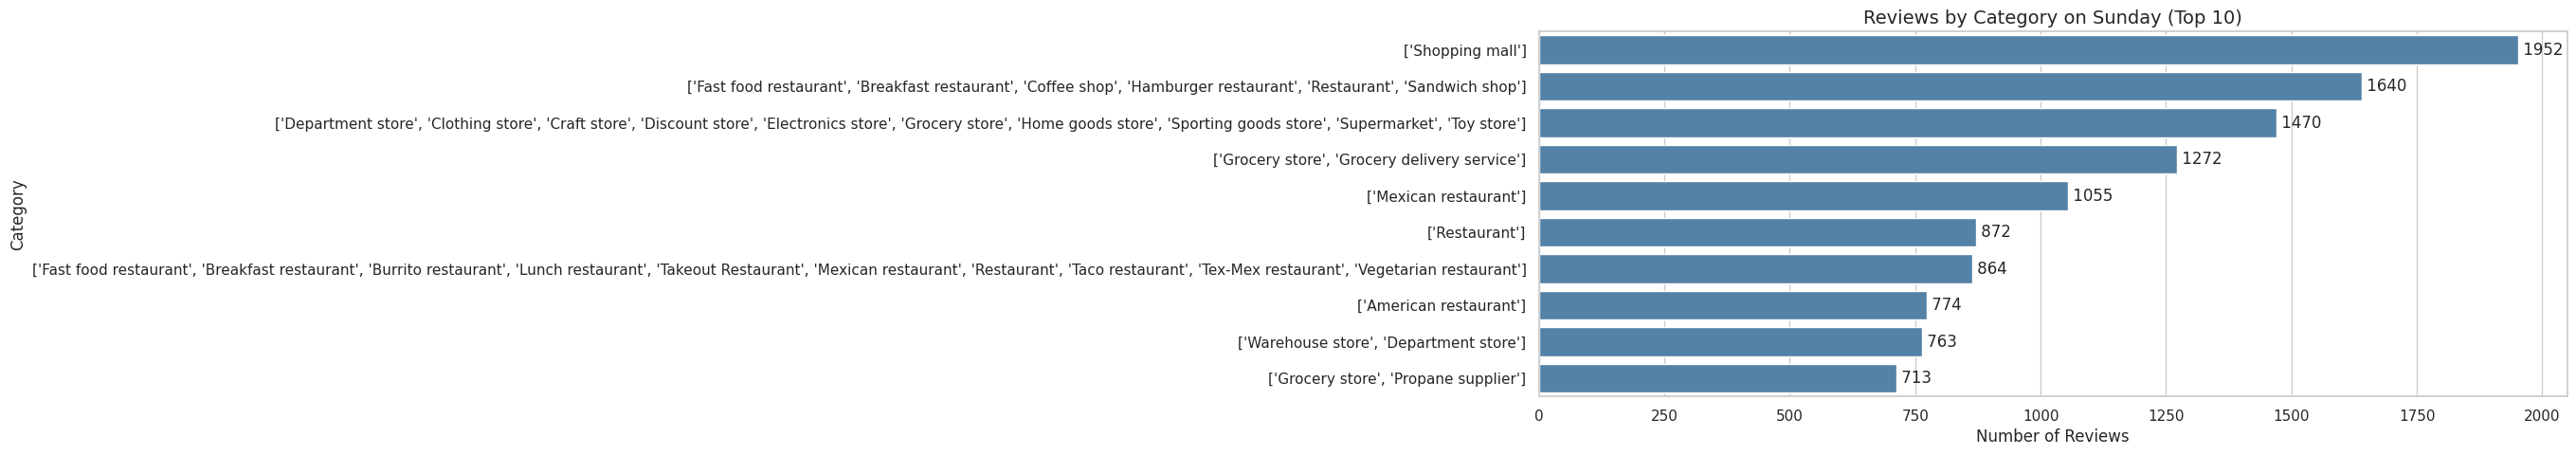

/tmp/ipython-input-4195989819.py:84: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


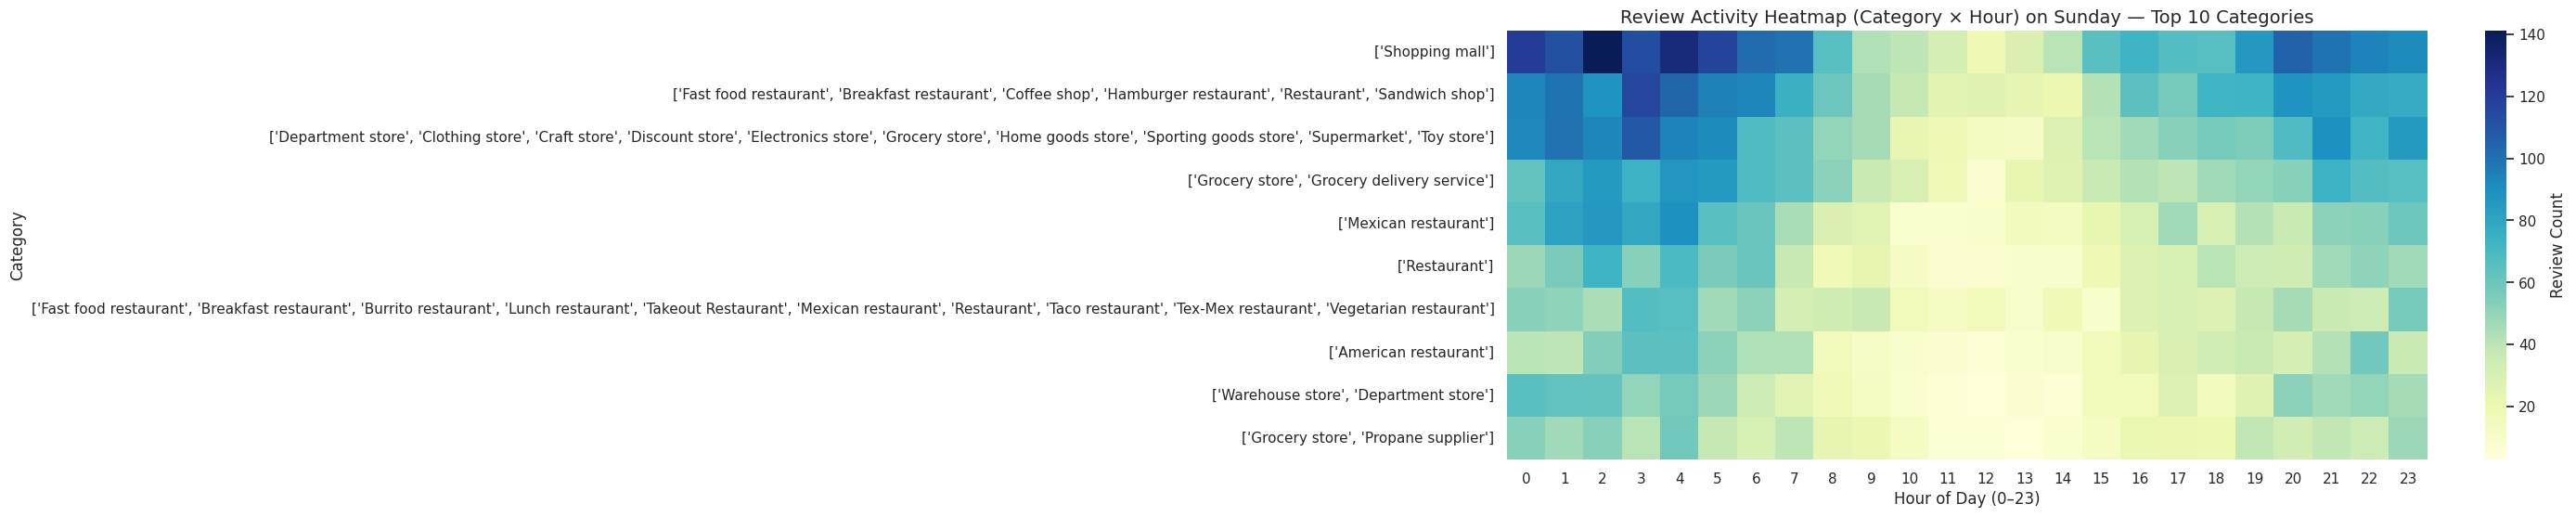


=== Peak Hour per Business on Sunday (Top 15) ===
                      business_name  review_time  peak_count
                         McDonald's            3         116
                Walmart Supercenter            3         109
                              Carrs            4          74
                          Taco Bell            3          67
                   Costco Wholesale            0          65
                         Fred Meyer            4          61
                            Wendy's            3          59
                    Texas Roadhouse            5          47
                          Starbucks           23          41
            Lowe's Home Improvement            1          38
                            Safeway            1          35
       Moose's Tooth Pub & Pizzeria            2          34
                      Dimond Center            4          33
                             Subway            2          33
Red Robin Gourmet Burgers and Brew

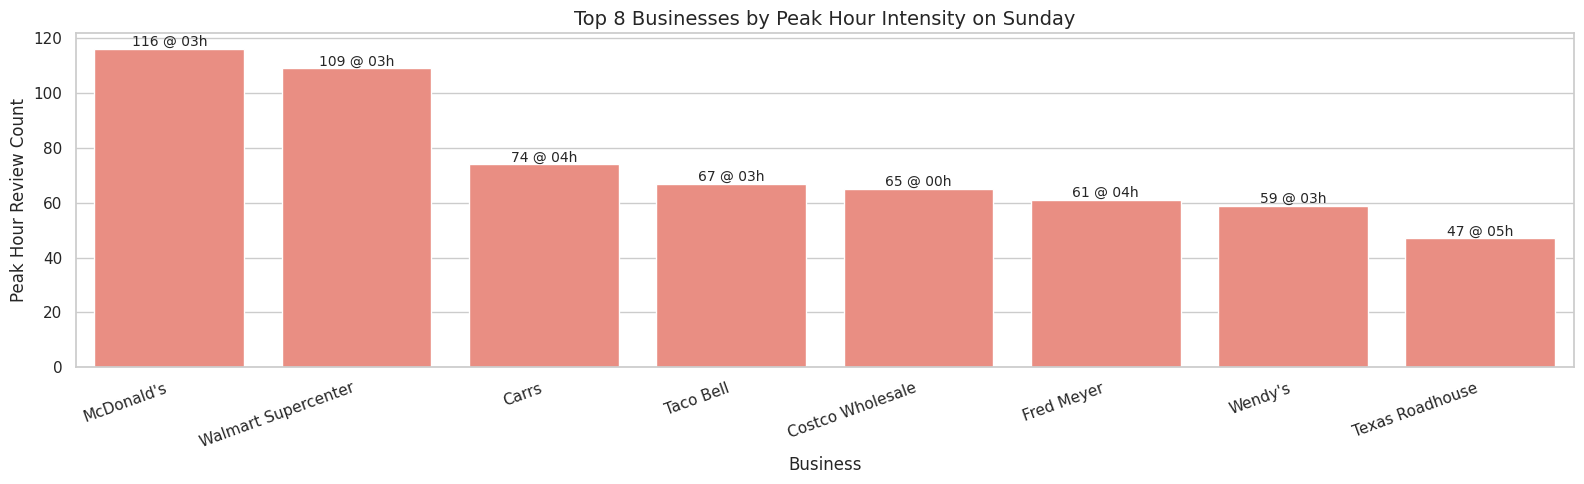

In [ ]:
# Q1.3.3 — Fast, formatted outputs for categories & peak hours
# --------------------------------------------------------------------
# 0) (Re)ensure review_time exists (hour of day) and cache peak subset
# --------------------------------------------------------------------
joined_df = joined_df.withColumn(
    "review_time", F.hour(F.from_unixtime(F.col("time").cast("bigint")/1000))
)

# If you don't already have peak_reviews from 1.3.2:
# peak_reviews = joined_df.filter(F.col("weekday") == F.lit(top_weekday))

peak_reviews = peak_reviews.select("category", "business_name", "review_time").cache()

# --------------------------------------------------------------------
# 1) Which categories dominate on the busiest weekday (TOP N only)
# --------------------------------------------------------------------
TOP_CAT = 10  # limit for plots to stay readable & fast

cat_counts_peak_spark = (
    peak_reviews.groupBy("category")
    .agg(F.count("*").alias("num_reviews"))
)

# Top N categories by volume
top_cat_spark = (
    cat_counts_peak_spark.orderBy(F.desc("num_reviews")).limit(TOP_CAT)
    .select("category")
)

# Pull the top-N counts for plotting (small Pandas df)
cat_counts_peak_top = (
    cat_counts_peak_spark.join(top_cat_spark, on="category", how="inner")
    .orderBy(F.desc("num_reviews"))
    .toPandas()
)

# Nicely formatted table (top N categories)
print(f"=== Reviews by Category on {top_weekday} (Top {TOP_CAT}) ===")
print(cat_counts_peak_top.to_string(index=False))

# Horizontal bar chart (clear labels)
plt.figure(figsize=(14, max(4, 0.5*len(cat_counts_peak_top))))
sns.barplot(
    y="category", x="num_reviews",
    data=cat_counts_peak_top,
    orient="h", color="steelblue"
)
plt.title(f"Reviews by Category on {top_weekday} (Top {TOP_CAT})", fontsize=14)
plt.xlabel("Number of Reviews", fontsize=12)
plt.ylabel("Category", fontsize=12)
for i, v in enumerate(cat_counts_peak_top["num_reviews"]):
    plt.text(v, i, f" {int(v)}", va="center")  # value labels
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 2) Category × Hour heatmap — only for the top categories (fast)
# --------------------------------------------------------------------
cat_hour_peak_top = (
    peak_reviews.join(top_cat_spark, on="category", how="inner")
    .groupBy("category", "review_time")
    .agg(F.count("*").alias("num_reviews"))
    .toPandas()
)

# Build a complete 0..23 column set even if some hours are missing
all_hours = list(range(24))
cat_hour_pivot = (
    cat_hour_peak_top
    .pivot(index="category", columns="review_time", values="num_reviews")
    .reindex(columns=all_hours)   # enforce 0..23 order
    .fillna(0)
)

# Order categories by their total to keep heatmap informative
cat_order = cat_hour_pivot.sum(axis=1).sort_values(ascending=False).index
cat_hour_pivot = cat_hour_pivot.loc[cat_order]

plt.figure(figsize=(16, max(6, 0.6*len(cat_hour_pivot))))
sns.heatmap(cat_hour_pivot, cmap="YlGnBu", cbar_kws={"label": "Review Count"})
plt.title(f"Review Activity Heatmap (Category × Hour) on {top_weekday} — Top {TOP_CAT} Categories", fontsize=14)
plt.xlabel("Hour of Day (0–23)", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------------
# 3) Peak hour per business on the busiest weekday (TOP M table + small bar)
# --------------------------------------------------------------------
TOP_BIZ = 15  # show a concise table
biz_hour_peak = (
    peak_reviews.groupBy("business_name", "review_time")
    .agg(F.count("*").alias("n"))
)

w = Window.partitionBy("business_name").orderBy(F.desc("n"), F.asc("review_time"))
biz_peak_hour = (
    biz_hour_peak.withColumn("rn", F.row_number().over(w))
    .filter(F.col("rn") == 1)
    .select("business_name", "review_time", "n")
    .orderBy(F.desc("n"))
    .limit(TOP_BIZ)
)

biz_peak_hour_pd = biz_peak_hour.toPandas()
biz_peak_hour_pd.rename(columns={"n":"peak_count"}, inplace=True)

print(f"\n=== Peak Hour per Business on {top_weekday} (Top {TOP_BIZ}) ===")
print(biz_peak_hour_pd.to_string(index=False))

# Optional: a small bar chart for the top 8 businesses by peak slot intensity
TOP_BIZ_PLOT = 8
plot_df = biz_peak_hour_pd.head(TOP_BIZ_PLOT).copy()
plt.figure(figsize=(16, 5))
sns.barplot(
    data=plot_df,
    x="business_name", y="peak_count", color="salmon"
)
plt.title(f"Top {TOP_BIZ_PLOT} Businesses by Peak Hour Intensity on {top_weekday}", fontsize=14)
plt.xlabel("Business", fontsize=12)
plt.ylabel("Peak Hour Review Count", fontsize=12)
plt.xticks(rotation=20, ha="right")
# annotate bars
for i, v in enumerate(plot_df["peak_count"].tolist()):
    plt.text(i, v, f"{int(v)} @ {int(plot_df.iloc[i]['review_time']):02d}h", ha="center", va="bottom", fontsize=10)
plt.tight_layout()
plt.show()


# **Observations**
## **Graph 1: Heatmap — Review Activity by Category × Hour on Sunday (Top 10 Categories)**

## **Dominant Categories**
* Shopping malls, fast food restaurants, grocery stores, and department stores show the highest review intensity.
* Restaurants (fast food, Mexican, American) also contribute strongly, but with varied time patterns.

## **Peak Hours**
* Most categories experience review surges in late evening (20:00–23:00) and also in the early morning (00:00–04:00).
* Midday (10:00–15:00) has relatively lower review activity, suggesting fewer people leave reviews during active shopping/eating times.

## **Category-Specific Patterns**
* Shopping malls dominate reviews especially around midnight to 3 a.m. and again at night.
* Fast food restaurants show consistent review counts across many hours, but * especially strong late at night.
* Grocery stores and warehouse stores spike late evening (after 18:00), matching shopping behavior.

## **Graph 2: Bar Chart — Top 8 Businesses by Peak Hour Intensity on Sunday**

## **Leading Businesses**
McDonald’s has the highest single-hour review count (116 at 03:00).
Walmart Supercenter follows closely (109 at 03:00).
This suggests fast-food chains and large retail outlets are the biggest magnets for Sunday reviews.

## **Other Notable Businesses**
* Carrs (74 @ 04:00) and Taco Bell (67 @ 03:00) reflect the late-night food trend.
* Costco Wholesale (65 @ 00:00) shows an unusual midnight peak, likely reflecting bulk shopping trips.
* Texas Roadhouse (47 @ 05:00) appears later in the morning, likely due to dining experiences.

## **Trend Insight**
* The majority of businesses peak between midnight and 5 a.m., showing that Sunday early hours are a hot window for reviews.
* Businesses tied to food and retail dominate these review peaks.

# **Answer 1.4**

=== Top 30 Most Common Words ===
food: 57725
place: 43147
service: 41207
staff: 25823
friendly: 24301
always: 21514
love: 18539
get: 16993
all: 16634
out: 15606
time: 15349
like: 13523
can: 13221
one: 12560
what: 11818
your: 11501
prices: 11032
people: 10838
store: 10580
has: 9884
will: 9830
helpful: 9552
back: 9295
excellent: 9276
some: 9260
only: 9017
little: 9010
selection: 8612
would: 8584
fast: 8504


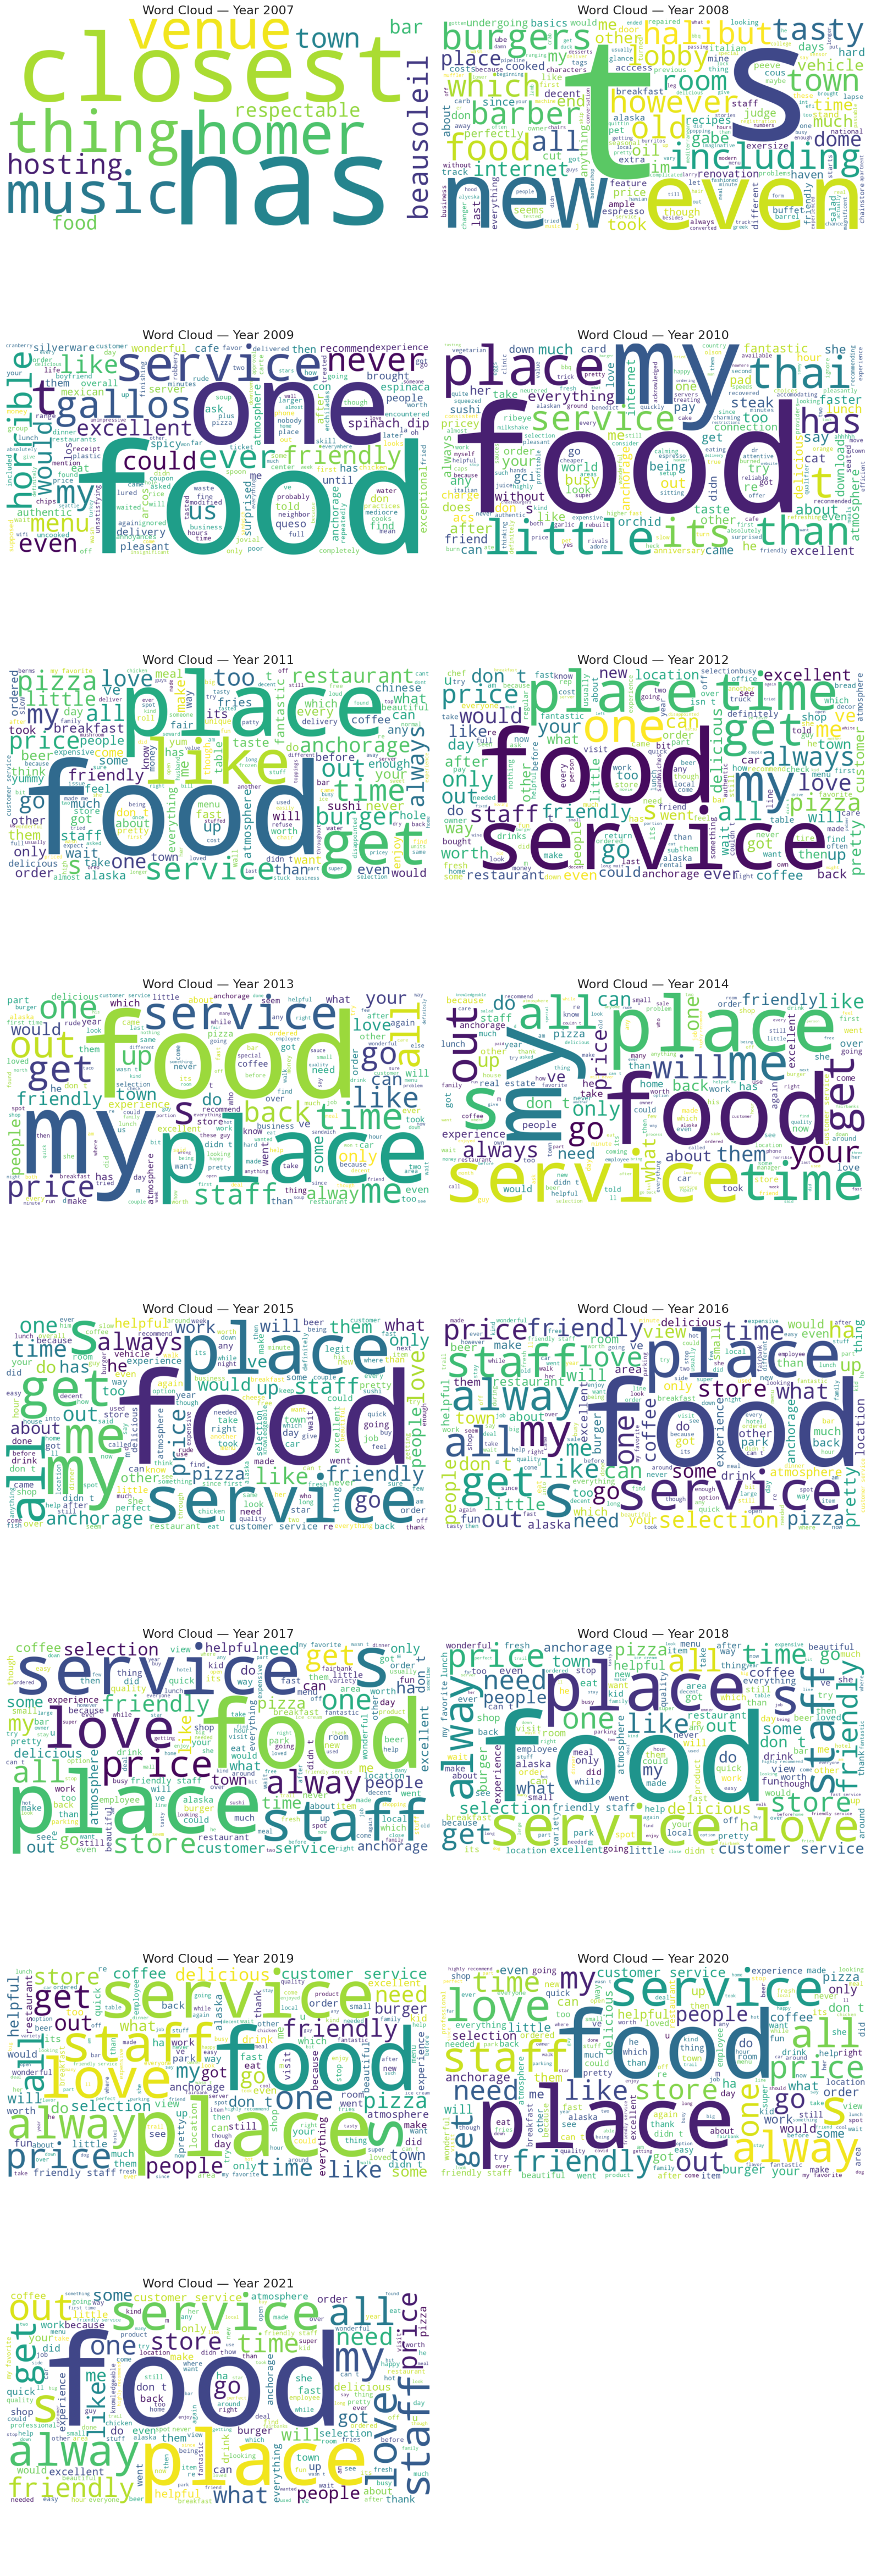

In [ ]:
# Q1.4 — Top 30 Words & Yearly Word Clouds
# -------------------------------------------------
# 1) Preprocess: ensure year and text are available
# -------------------------------------------------
joined_df = joined_df.withColumn(
    "review_year", F.year(F.from_unixtime(F.col("time").cast("bigint")/1000))
)
joined_df = joined_df.withColumn(
    "text",
    F.when(F.col("text").isNull(), F.lit("no review")).otherwise(F.col("text"))
)

# -------------------------------------------------
# 2) Text cleaning helper
# -------------------------------------------------
def clean_text(t: str) -> str:
    if not t:
        return ""
    t = t.lower()
    t = re.sub(r"[^a-z\s]", " ", t)   # keep only letters/spaces
    t = re.sub(r"\s+", " ", t).strip()
    return t

stopwords = set("""
the and a to of it is for on in at was with this that are as be we they you i an so but very not our have had from here there by were been when or if their
no review good great nice clean awesome amazing best worst better bad ok okay well really just also more most less lot lots
""".split())

# -------------------------------------------------
# 3) Top 30 most common words (all reviews)
# -------------------------------------------------
texts_all = (
    joined_df.select("text")
    .rdd.flatMap(lambda row: [row["text"]])
    .map(clean_text)
    .filter(lambda s: s != "")
    .collect()
)

all_words = []
for s in texts_all:
    all_words.extend([w for w in s.split() if w not in stopwords and len(w) > 2])

top30 = Counter(all_words).most_common(30)

print("=== Top 30 Most Common Words ===")
for w, c in top30:
    print(f"{w}: {c}")

# -------------------------------------------------
# 4) Word clouds per year
# -------------------------------------------------
texts_by_year = (
    joined_df.filter(F.col("review_year").isNotNull())
    .select("review_year", "text")
    .rdd.map(lambda r: (int(r["review_year"]), clean_text(r["text"] or "")))
    .filter(lambda kv: kv[1] != "")
    .groupByKey()
    .mapValues(lambda texts: " ".join(texts))
    .collect()
)

texts_by_year = sorted(texts_by_year, key=lambda x: x[0])  # sort by year

if texts_by_year:
    n = len(texts_by_year)
    ncols = 2 if n > 1 else 1
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 6*nrows))
    axes = axes.flatten() if n > 1 else [axes]

    for ax, (year, textblob) in zip(axes, texts_by_year):
        wc = WordCloud(width=1200, height=600, background_color="white", stopwords=stopwords).generate(textblob)
        ax.imshow(wc, interpolation="bilinear")
        ax.axis("off")
        ax.set_title(f"Word Cloud — Year {year}", fontsize=16)

    # Hide unused axes
    for ax in axes[len(texts_by_year):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No yearly texts found to generate word clouds.")


# **Answer 1.5**

=== Top 15 Businesses by Unique Reviewers ===
+-----------------------------------+----------------+
|business_name                      |unique_reviewers|
+-----------------------------------+----------------+
|Walmart Supercenter                |6976            |
|McDonald's                         |6857            |
|Carrs                              |4352            |
|Costco Wholesale                   |4352            |
|Taco Bell                          |4322            |
|Fred Meyer                         |3598            |
|Wendy's                            |3156            |
|Safeway                            |2796            |
|Moose's Tooth Pub & Pizzeria       |2737            |
|Subway                             |2732            |
|Dimond Center                      |2504            |
|Lowe's Home Improvement            |2370            |
|Anchorage 5th Avenue Mall          |2054            |
|Red Robin Gourmet Burgers and Brews|1980            |
|Starbucks         

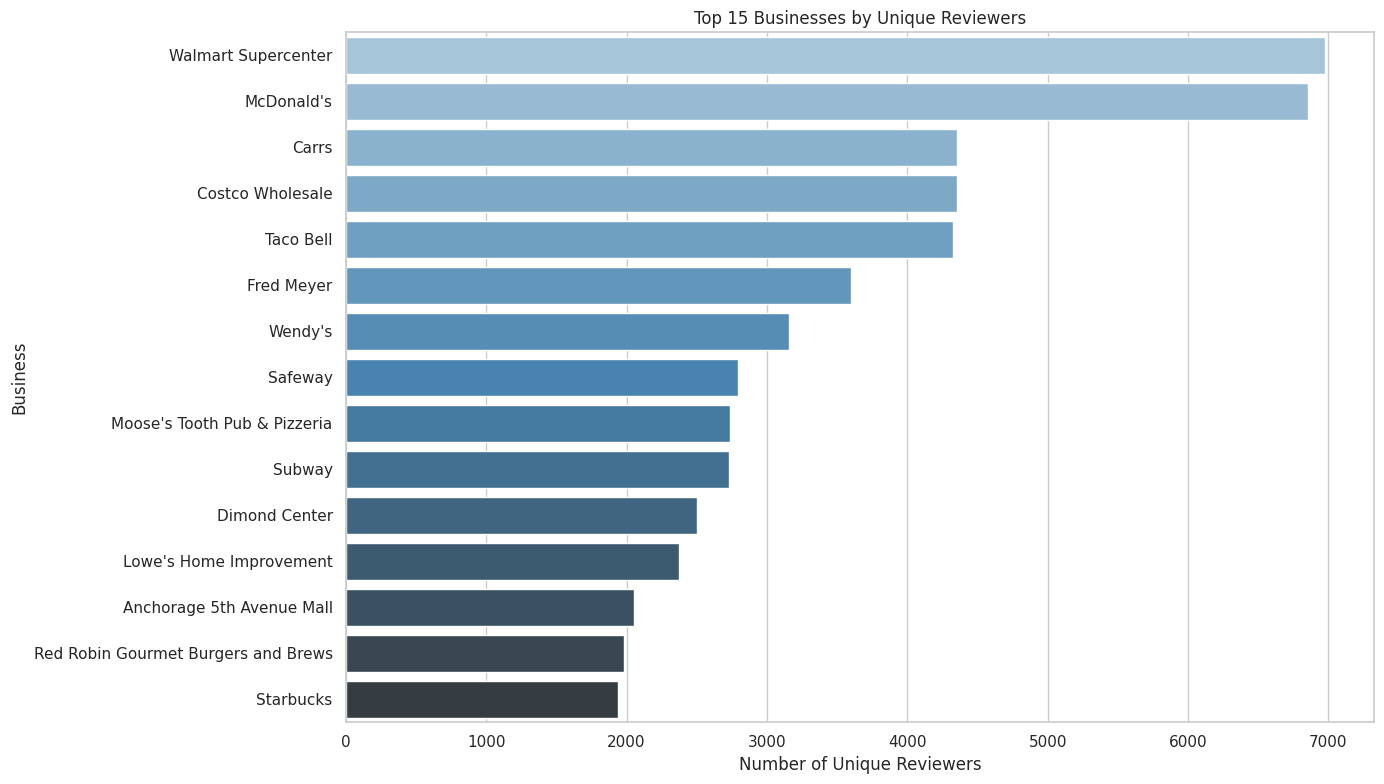

/tmp/ipython-input-78929738.py:87: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


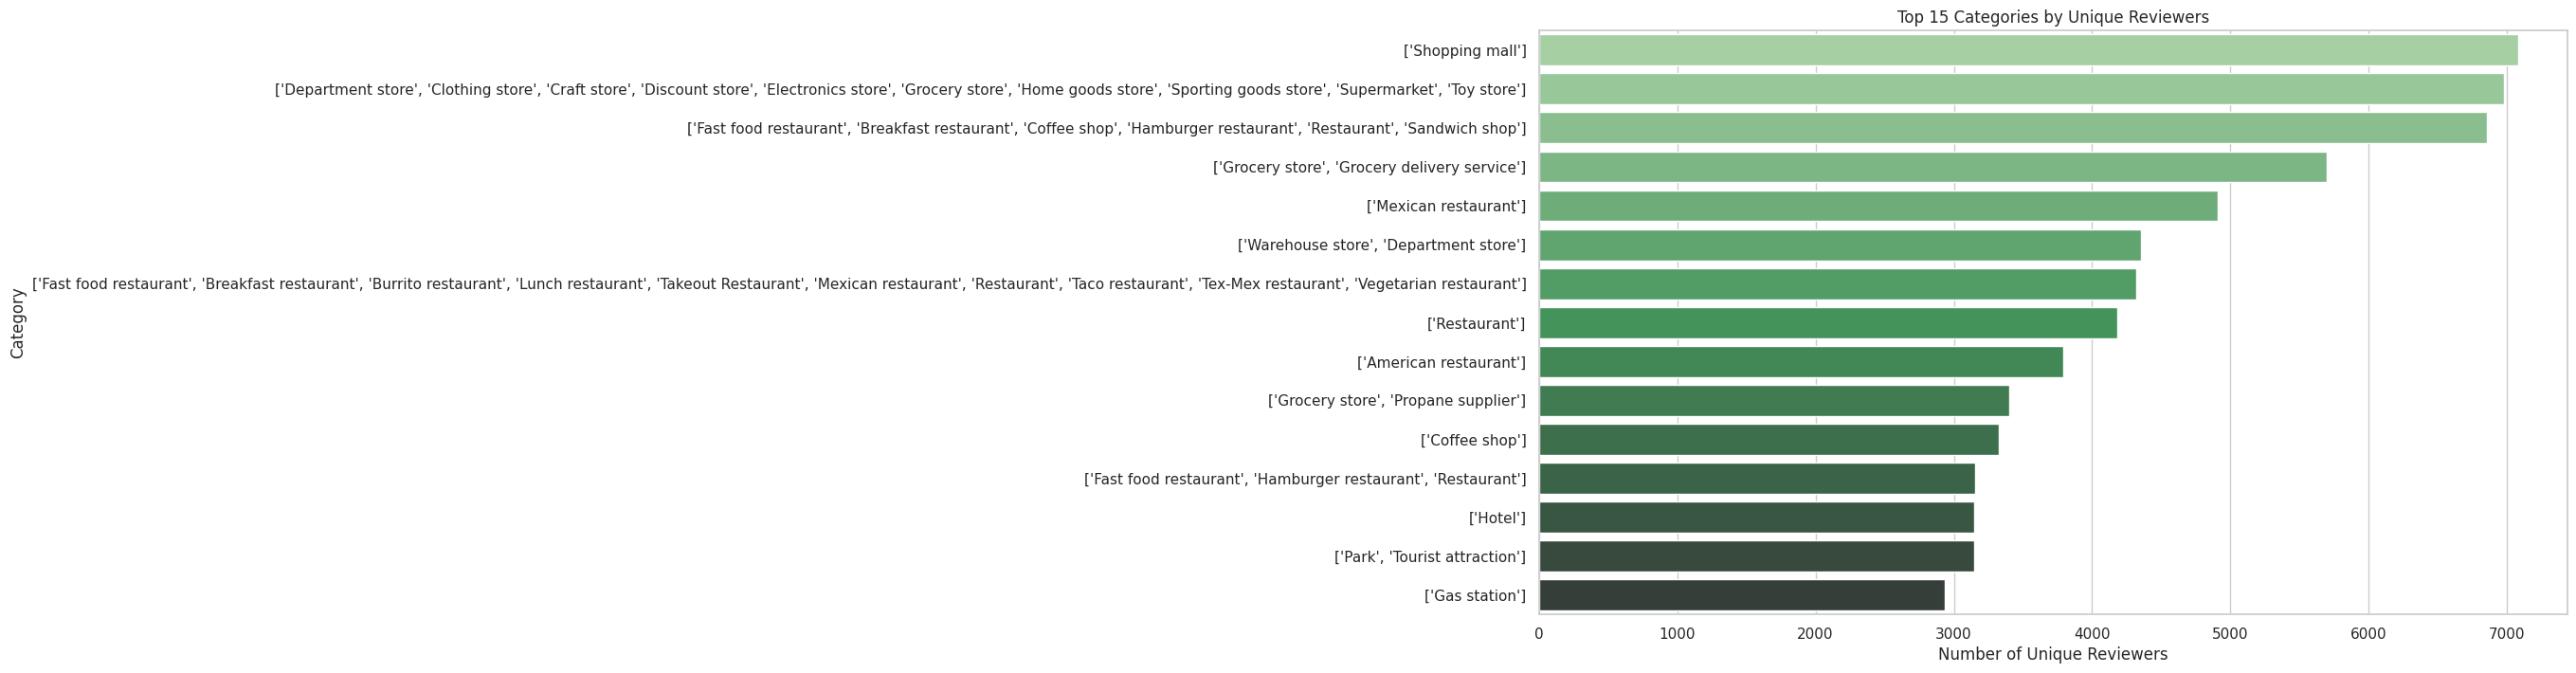

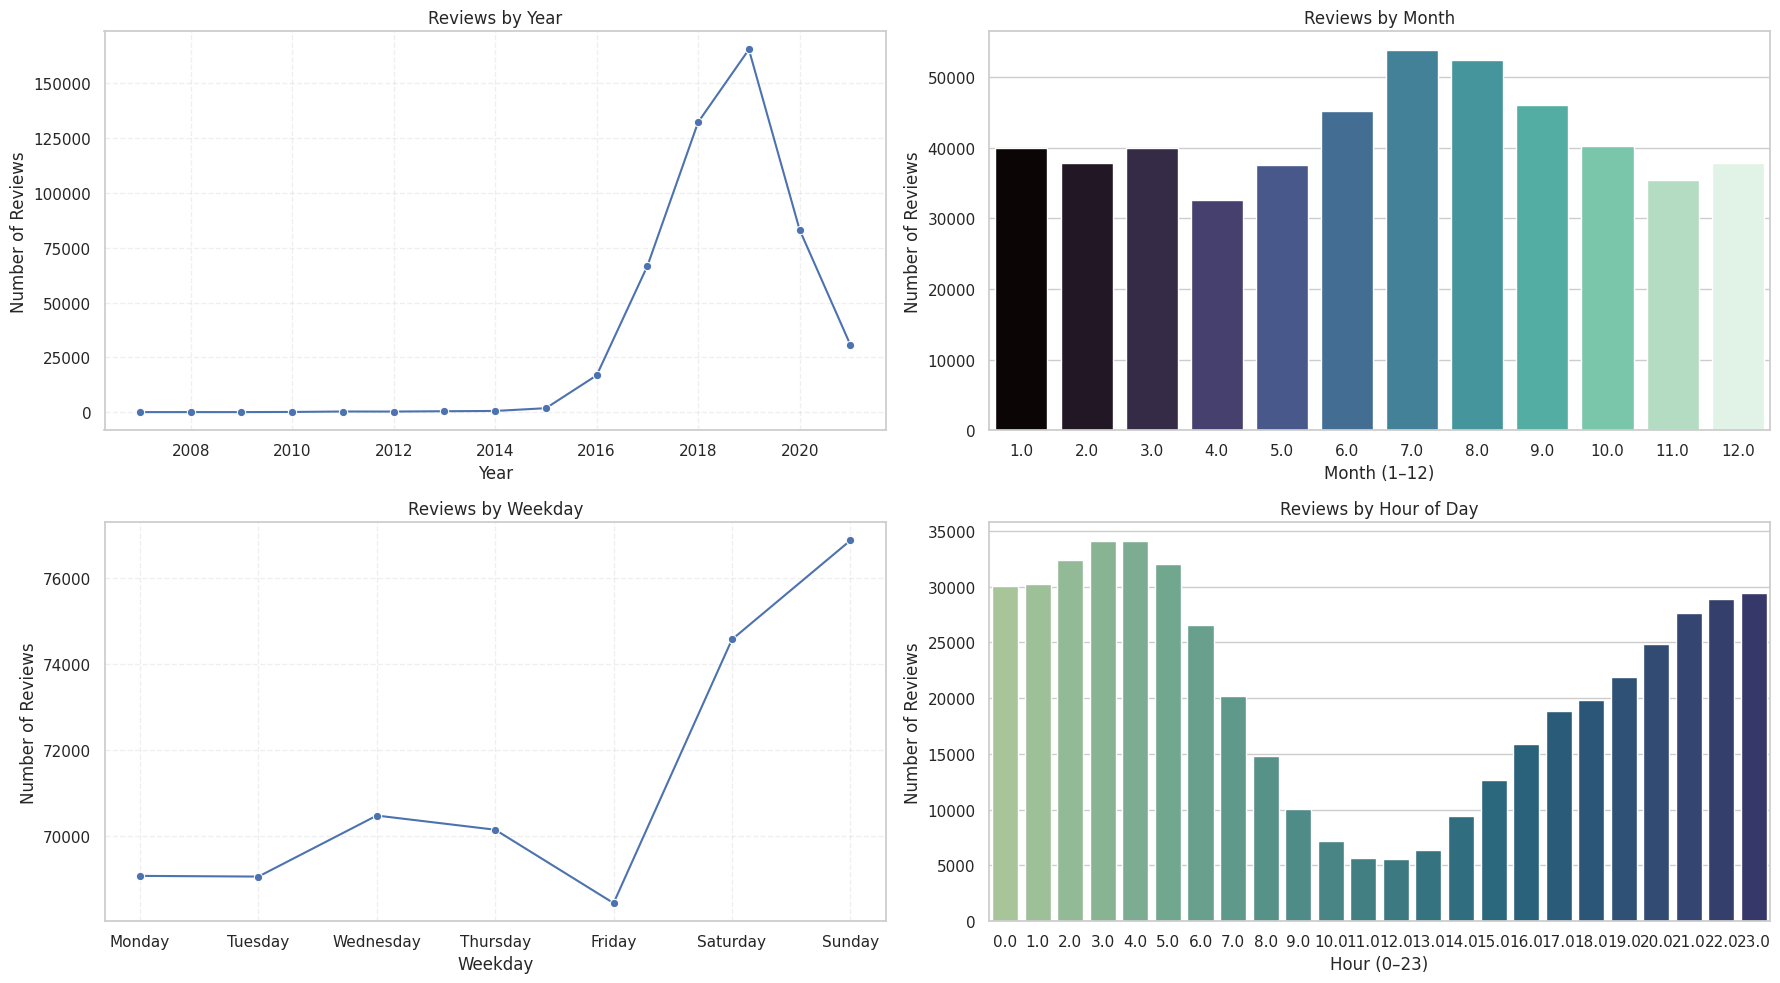


=== Winners (Distinct Reviewers) ===
Top Business:  Walmart Supercenter  — 6976 unique reviewers
Top Category:  ['Shopping mall']  — 7081 unique reviewers


In [ ]:
# Q1.5 — Unique reviewers (business & category) + temporal submission patterns
# Assumes you already have `joined_df` (reviews ⨝ meta on gmap_id) and Spark session.
# -----------------------------
# 0) Ensure needed time columns
# -----------------------------
# newtime: yyyy-MM-dd; hour; weekday name; year; month
joined_df = (
    joined_df
    .withColumn("newtime", F.to_date(F.from_unixtime(F.col("time").cast("bigint")/1000)))
    .withColumn("hour", F.hour(F.from_unixtime(F.col("time").cast("bigint")/1000)))
    .withColumn("weekday", F.date_format(F.col("newtime"), "EEEE"))
    .withColumn("year", F.year(F.col("newtime")))
    .withColumn("month", F.month(F.col("newtime")))
)

# ============================================================
# 1) Unique reviewers per BUSINESS and per CATEGORY (Spark)
# ============================================================
unique_reviewers_biz = (
    joined_df.groupBy("business_name")
    .agg(F.countDistinct("user_id").alias("unique_reviewers"))
    .orderBy(F.desc("unique_reviewers"))
)

unique_reviewers_cat = (
    joined_df.groupBy("category")
    .agg(F.countDistinct("user_id").alias("unique_reviewers"))
    .orderBy(F.desc("unique_reviewers"))
)

print("=== Top 15 Businesses by Unique Reviewers ===")
unique_reviewers_biz.show(15, truncate=False)

print("=== Top 15 Categories by Unique Reviewers ===")
unique_reviewers_cat.show(15, truncate=False)

# Convert *small* tops to Pandas for plotting
topK_biz = 15
topK_cat = 15
biz_reviewers_pd = unique_reviewers_biz.limit(topK_biz).toPandas()
cat_reviewers_pd = unique_reviewers_cat.limit(topK_cat).toPandas()

# Keep readable sort order
biz_reviewers_pd = biz_reviewers_pd.sort_values("unique_reviewers", ascending=False)
cat_reviewers_pd = cat_reviewers_pd.sort_values("unique_reviewers", ascending=False)

# ============================================================
# 2) Temporal patterns (counts by year / month / weekday / hour)
# ============================================================
reviews_by_year = joined_df.groupBy("year").agg(F.count("*").alias("count")).orderBy("year").toPandas()
reviews_by_month = joined_df.groupBy("month").agg(F.count("*").alias("count")).orderBy("month").toPandas()
reviews_by_weekday = joined_df.groupBy("weekday").agg(F.count("*").alias("count")).toPandas()
reviews_by_hour = joined_df.groupBy("hour").agg(F.count("*").alias("count")).orderBy("hour").toPandas()

# Order weekdays logically
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
reviews_by_weekday["weekday"] = pd.Categorical(reviews_by_weekday["weekday"], categories=weekday_order, ordered=True)
reviews_by_weekday = reviews_by_weekday.sort_values("weekday")

# ============================================================
# 3) Visualizations (warnings-proof: set hue to same variable)
# ============================================================

# --- Top businesses by unique reviewers ---
plt.figure(figsize=(14, 8))
sns.barplot(
    data=biz_reviewers_pd,
    y="business_name", x="unique_reviewers",
    hue="business_name", palette="Blues_d", dodge=False, legend=False
)
plt.title(f"Top {topK_biz} Businesses by Unique Reviewers")
plt.xlabel("Number of Unique Reviewers")
plt.ylabel("Business")
plt.tight_layout()
plt.show()

# --- Top categories by unique reviewers ---
plt.figure(figsize=(14, 8))
sns.barplot(
    data=cat_reviewers_pd,
    y="category", x="unique_reviewers",
    hue="category", palette="Greens_d", dodge=False, legend=False
)
plt.title(f"Top {topK_cat} Categories by Unique Reviewers")
plt.xlabel("Number of Unique Reviewers")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# --- Temporal grid: year, month, weekday, hour ---
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Year (line)
sns.lineplot(
    data=reviews_by_year, x="year", y="count", marker="o", ax=axes[0,0]
)
axes[0,0].set_title("Reviews by Year")
axes[0,0].set_xlabel("Year")
axes[0,0].set_ylabel("Number of Reviews")
axes[0,0].grid(alpha=0.3, linestyle="--")

# Month (bar) – set hue to same variable to avoid future warning
sns.barplot(
    data=reviews_by_month, x="month", y="count",
    hue="month", dodge=False, legend=False, palette="mako",
    ax=axes[0,1]
)
axes[0,1].set_title("Reviews by Month")
axes[0,1].set_xlabel("Month (1–12)")
axes[0,1].set_ylabel("Number of Reviews")

# Weekday (line)
sns.lineplot(
    data=reviews_by_weekday, x="weekday", y="count", marker="o", ax=axes[1,0]
)
axes[1,0].set_title("Reviews by Weekday")
axes[1,0].set_xlabel("Weekday")
axes[1,0].set_ylabel("Number of Reviews")
axes[1,0].grid(alpha=0.3, linestyle="--")

# Hour (bar) – set hue to same variable to avoid future warning
sns.barplot(
    data=reviews_by_hour, x="hour", y="count",
    hue="hour", dodge=False, legend=False, palette="crest",
    ax=axes[1,1]
)
axes[1,1].set_title("Reviews by Hour of Day")
axes[1,1].set_xlabel("Hour (0–23)")
axes[1,1].set_ylabel("Number of Reviews")

plt.tight_layout()
plt.show()

# ============================================================
# 4) Optional: exact winners for your report
# ============================================================
top_business = unique_reviewers_biz.first()
top_category = unique_reviewers_cat.first()
print("\n=== Winners (Distinct Reviewers) ===")
print(f"Top Business:  {top_business['business_name']}  — {top_business['unique_reviewers']} unique reviewers")
print(f"Top Category:  {top_category['category']}  — {top_category['unique_reviewers']} unique reviewers")
